In [1]:
# REF
# https://github.com/jackyko1991/Image-Transform/blob/master/main.py

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import scipy
from numba import cuda
from tqdm import trange

In [3]:
import scipy.ndimage as ndimage

In [178]:
moving_image, header = nrrd.read("20231013_191710_ref_2678_2805.nrrd")
ref_image, header = nrrd.read("20231013_191710_ref_19414_19584.nrrd")

In [179]:
nMu = [20,0]

affine_matrix = np.array([[1, 0, nMu[0]], [0, 1, nMu[1]], [0, 0, 1]])

In [180]:
ref_image = ref_image[500:600,500:600,60]
moving_image = ndimage.affine_transform(ref_image, affine_matrix, output_shape = (ref_image.shape))

In [181]:
ref_image.shape

(100, 100)

In [182]:
nMu = [-20,0]

affine_matrix = np.array([[1, 0, nMu[0]], [0, 1, nMu[1]], [0, 0, 1]])

In [183]:
moving_image_out = ndimage.affine_transform(moving_image, affine_matrix, output_shape = (ref_image.shape))

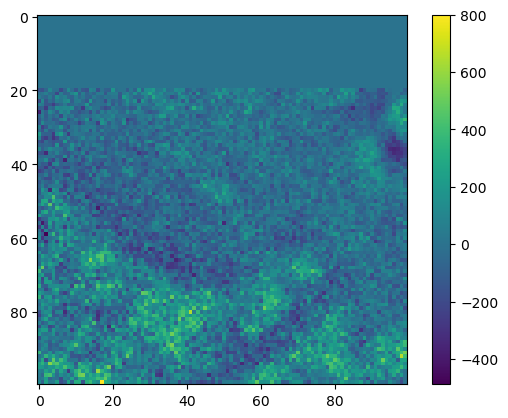

In [184]:
plt.imshow(moving_image_out[:,:])
plt.colorbar()

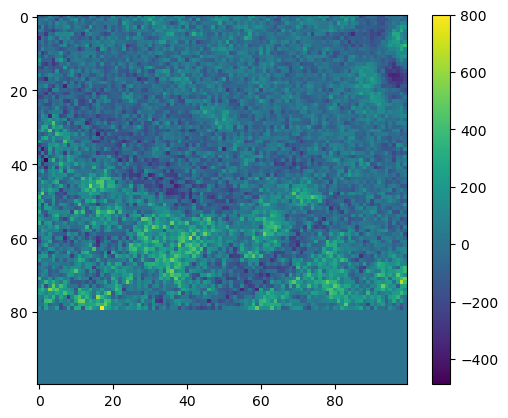

In [185]:
plt.imshow((moving_image[:,:]))
plt.colorbar()

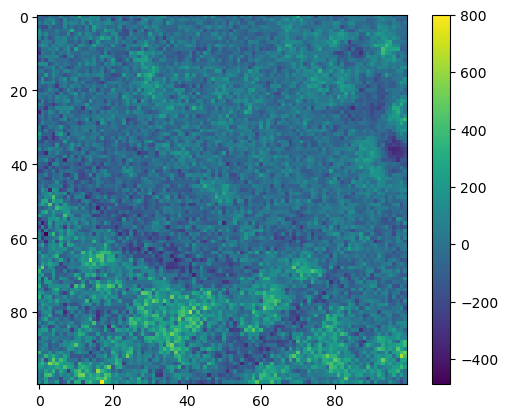

In [186]:
plt.imshow((ref_image[:,:]))
plt.colorbar()

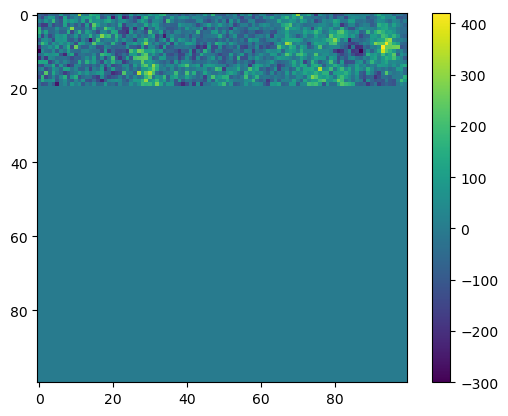

In [187]:
plt.imshow(ref_image[:,:]-moving_image_out[:,:])
plt.colorbar()

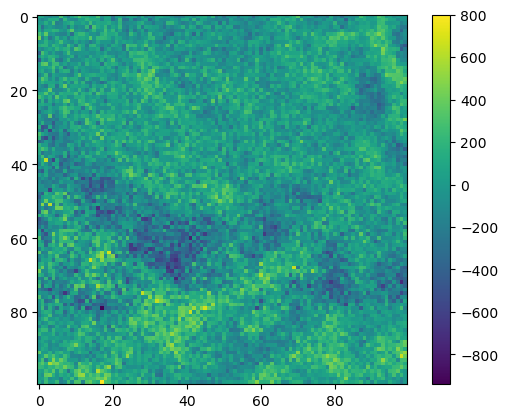

In [188]:
plt.imshow(ref_image[:,:]-moving_image[:,:])
plt.colorbar()

In [263]:
def mbImageGradient(F):
    # retrun:
    # image gradient for each dimension: [dF/dx,dF/dy,...]
    # image magnitude dFmag= math.sqrt(dx^2+dy^2)
    # image direction: theta = math.atan(dy/dx)

    # using Sobel kernel
    # SbX2D = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    # SbY2D = np.array([[1,2,1 ],[0,0,0 ],[-1,-2,-1]])
    # dX = ndimage.convolve(F, SbX2D, mode='constant', cval=0.0)
    # dY = ndimage.convolve(F, SbY2D, mode='constant', cval=0.0)


    dX = ndimage.sobel(F,axis=0,mode='constant', output = np.int32)
    dY = ndimage.sobel(F,axis=1,mode='constant', output = np.int32)
    
    g = np.dstack((dX,dY))
    return g

#mse derivative  
def mbdMSE(u,v,dT):
    # dMSE the derivative of mse with repect to the transform parameters mu
    # dM   =  d M(y)/ dy    # gradient of the transformed moving image
    # dT   =  D T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
    # dMdT = d M(y)/ dy * D T(x,mu) / dmu

    dMSE  = 0.0
    # compute the gradient of the transformed image
    #dM = imGradient(v)
    dM = mbImageGradient(v)

    # the first term in eq.4, a scalar
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    dmse = (2/float(n))* (v-u)

    # second and third terms in eq.4 
    dMdT = np.array([0.0,0.0])
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0]) 
            dxy1 = np.dot([dx,dy],dT[:,1])             
            dMdT[0] = dMdT[0] + dmse[i,j]*dxy0 
            dMdT[1] = dMdT[1] + dmse[i,j]*dxy1
            # we can also use the gradient directly as dT is just identity matrix
            # dMdT[0] = dMdT[0] + dmse[i,j]*dx
            # dMdT[1] = dMdT[1] + dmse[i,j]*dy

    dMSE = np.array([dMdT[0], dMdT[1]])
    return     dMSE  # this should be a vector of length d dimension


# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    # initial parameters 
    nMu = [10,0]
    dT = np.array([[1,0],[0,1]])

    mv_all = []
    # start the optimisation
    for i in range(numIterations):
        # transform the moving image using nMu
        affine_matrix = np.array([[1, 0, nMu[0]], [0, 1, nMu[1]], [0, 0, 1]])

        v_t = ndimage.affine_transform(v, affine_matrix, output_shape = (ref_image.shape))
        tMshow = 0
        if tMshow:
            f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
            f.add_subplot(1,2, 1)
            plt.imshow(v_t)
        #compute the metric value
        mv = mseMetric(u,v_t)
        # compute the metric derivative
        dMu = mbdMSE(u,v_t,dT)        
        # update the parameters 
        nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
        print(i,": ",mv," , ", nMu)

        mv_all.append(mv)

    plt.figure()
    plt.plot(mv_all)
    return nMu

#mse metric
def mseMetric(u,v):
    mbMSE  = 0.0
    n = 1
    for i in range(len(u.shape)): 
        n =  n * u.shape[i]  
    mbMSE  = np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / float(n)
    #mbSMSE = math.sqrt(mbMSE)
    return mbMSE

In [264]:
u,v = moving_image, ref_image

nMu = [20,0]

affine_matrix = np.array([[1, 0, nMu[0]], [0, 1, nMu[1]], [0, 0, 1]])

v_t = ndimage.affine_transform(v, affine_matrix, output_shape = (ref_image.shape))
mv = mseMetric(u,v_t)
mv

0.0

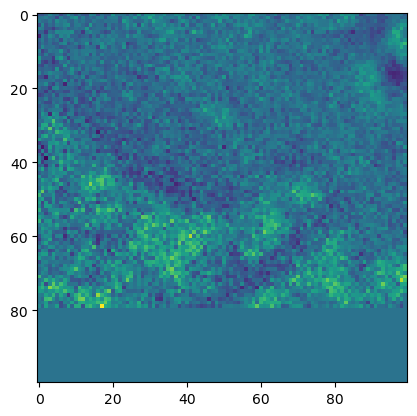

In [265]:
plt.imshow(v_t)

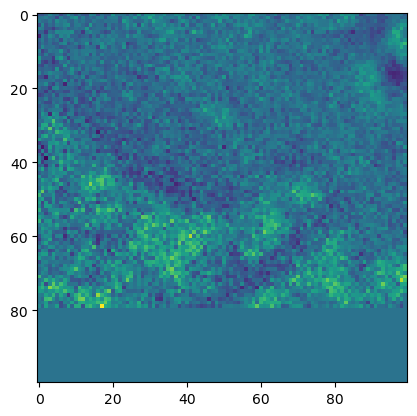

In [266]:
plt.imshow(u)

0 :  30838.5952  ,  [10.46668989 -0.12980158]
1 :  27766.3872  ,  [10.98497993 -0.2552917 ]
2 :  28668.6336  ,  [11.58023379 -0.37893443]
3 :  25730.0176  ,  [12.24420284 -0.47454789]
4 :  25420.0672  ,  [13.00281652 -0.51160586]
5 :  25377.968  ,  [13.92421811 -0.48180957]
6 :  24337.1152  ,  [15.001218   -0.41627107]
7 :  22607.7568  ,  [16.24856489 -0.26130105]
8 :  19954.2496  ,  [17.7945986  -0.03916758]
9 :  17783.9024  ,  [18.98964041 -0.04441645]
10 :  16867.6416  ,  [2.30006630e+01 1.74108296e-02]
11 :  20410.7408  ,  [21.56946266 -0.10075542]
12 :  17281.776  ,  [18.87707546  0.15942222]
13 :  17541.7024  ,  [22.7591687 -0.5000046]
14 :  17301.4112  ,  [21.44486303 -0.32672246]
15 :  16136.1728  ,  [18.50369264  0.34724564]
16 :  16110.9024  ,  [21.32324075 -0.37935308]
17 :  16041.7152  ,  [18.12181248  0.51430554]
18 :  16350.6272  ,  [19.7493192   0.02679181]
19 :  1074.1528  ,  [21.15645461 -0.27235334]
20 :  16669.1936  ,  [17.50188487  0.57668292]
21 :  16090.6048  ,  [

array([19.36825298,  1.62520619])

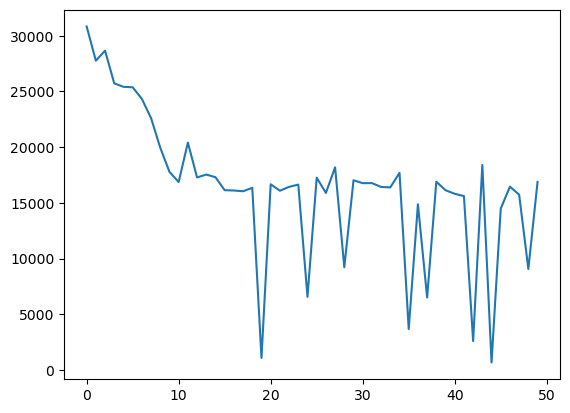

In [272]:
gdOptimiser(moving_image, ref_image, 50, 0.0001)

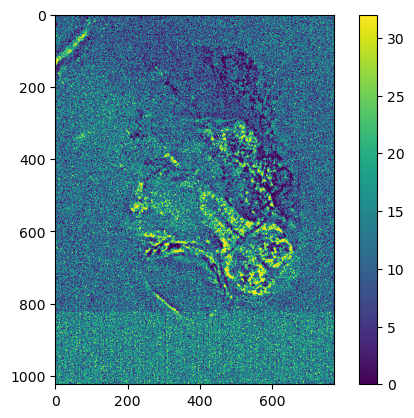

In [51]:
# https://github.com/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example_mse_translation_GradientDescent.ipynb
# mse derivative

# dMSE the derivative of mse with repect to the transform parameters mu
# dM   =  d M(y)/ dy    # gradient of the transformed moving image
# dT   =  d T(x,mu) / dmu # gradient of the transformation with respect to its parameters mu 
# dMdT = d M(y)/ dy * d T(x,mu) / dmu

# compute the gradient of the transformed image

# the first term in eq.4, a scalar

n =  np.product(ref_image_gpu.shape, dtype= np.uint16)
dmse = np.multiply(np.float32(2/n) , (moving_image_out_gpu-ref_image_gpu))

plt.imshow((dmse[:,:]))
plt.colorbar()

dmse = dmse.flatten()

In [54]:
sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant', output = np.int32)
sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant', output = np.int32)

sx = sx.flatten()
sy = sy.flatten()

In [56]:
W, H = moving_image_out_gpu.shape

In [57]:
x = np.arange(W, dtype = np.uint16)
y = np.arange(H, dtype = np.uint16)
x_t, y_t  = np.meshgrid(x,y)
x_t = x_t.flatten()
y_t = y_t.flatten()

In [58]:
dMu  = np.array([
        np.sum(x_t*sx*dmse, dtype=np.float32), np.sum(y_t*sx*dmse, dtype=np.float32), np.sum(sx*dmse, dtype=np.float32),
        np.sum(x_t*sy*dmse, dtype=np.float32), np.sum(y_t*sy*dmse, dtype=np.float32), np.sum(sy*dmse, dtype=np.float32),
         ])

In [59]:
dMu

array([ 1.5224425e+09, -4.1899088e+08,  1.0951545e+06, -1.3029205e+08,
       -3.3877011e+08, -1.3713910e+06], dtype=float32)

In [80]:
numIterations = 10
stepSize = 10**-10
nMu = np.array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
affine_matrix = np.vstack([nMu.reshape(3,4), [0,0,0,1]])
for i in trange(numIterations):
    v = ndimage.affine_transform(moving_image_gpu, affine_matrix_gpu, output_shape = (ref_image_gpu.shape))


    dmse = np.multiply(np.float32(2/n) , (moving_image_out_gpu-ref_image_gpu))
    dmse = dmse.flatten()

    
    sx = ndimage.sobel(moving_image_out_gpu,axis=0,mode='constant', output = np.int32)
    sy = ndimage.sobel(moving_image_out_gpu,axis=1,mode='constant', output = np.int32)
    sz = ndimage.sobel(moving_image_out_gpu,axis=2,mode='constant', output = np.int32)
    
    sx = sx.flatten()
    sy = sy.flatten()
    sz = sy.flatten()

    dMu  = np.array([
            np.sum(x_t*sx*dmse, dtype=np.float32), np.sum(y_t*sx*dmse, dtype=np.float32), np.sum(z_t*sx*dmse, dtype=np.float32), np.sum(sx*dmse, dtype=np.float32),
            np.sum(x_t*sy*dmse, dtype=np.float32), np.sum(y_t*sy*dmse, dtype=np.float32), np.sum(z_t*sy*dmse, dtype=np.float32), np.sum(sy*dmse, dtype=np.float32),
            np.sum(x_t*sz*dmse, dtype=np.float32), np.sum(y_t*sz*dmse, dtype=np.float32), np.sum(z_t*sz*dmse, dtype=np.float32), np.sum(sz*dmse, dtype=np.float32),
             ])
    nMu = nMu - ( stepSize * dMu )


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


In [81]:
nMu

array([ 3.86041365e+01,  7.34663725e+01,  9.62343141e-01,  8.68011545e-02,
       -1.46773934e+01, -9.18849015e+00, -1.43839344e-01, -1.76957517e-02,
       -1.46773934e+01, -1.01884902e+01,  8.56160656e-01, -1.76957517e-02])

In [18]:
# # image registration using gradient descent
# def gdOptimiser(u,v,numIterations,stepSize):
#     # initial parameters 
#     nMu = [0,0]
#     dT = np.array([[1,0],[0,1]])
#     # start the optimisation
#     for i in range(numIterations):
#         # transform the moving image using nMu
#         v_t = imTransform(v,nMu)
#         tMshow = 0
#         if tMshow:
#             f = plt.figure();f.set_figheight(15);f.set_figwidth(15)
#             f.add_subplot(1,2, 1)
#             plt.imshow(v_t)
#         #compute the metric value
#         mv = mseMetric(u,v_t)
#         # compute the metric derivative
#         dMu = mbdMSE(u,v_t,dT)        
#         # update the parameters 
#         nMu = np.array(nMu) - ( stepSize * np.array(dMu ))
#         print(i,": ",mv," , ", nMu)
#     return nMu

# print("numIterations : ", numIterations)
# print("stepSize      : ", stepSize)   

# # numIterations = 119
# # stepSize      = 15